In [1]:
from rdkit import Chem
#from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Descriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdMolDescriptors as rdescriptors
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import Draw

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

I chose Tyrosin kinase receptor FLT3. Not because it would be my favorite but because it was the first one I could find with a pleasant number of 5637 entries with IC50 values.

In [2]:
df = pd.read_csv('tyrosin_kinase_receptor_FLT3.csv', sep = ';')

At first, I loaded the data using pandas, I converted SMILES to molecule object using iteration through respective SMILES column. It worked nicely, no errors occured, smiles from each line were successfully converted.

In [3]:
molecules = [Chem.MolFromSmiles(smiles) for smiles in df['Smiles']]
len(df) == len(molecules)

True

I also loaded molecules from drugbank for comparison, there is 7115 of them.

In [4]:
suppl = Chem.SDMolSupplier('drugbank.sdf')
drugbank = [m for m in suppl if m]

# Descriptors

In [5]:
def lipinsky_ro5(molecules):
    lipinski = []
    for molecule in molecules:
        rules = [False, False, False, False]
        if Chem.Lipinski.NumHAcceptors(molecule) <= 10:
            rules[0] = True
        if Chem.Lipinski.NumHDonors(molecule) <= 5:
            rules[1] = True 
        if Descriptors.MolWt(molecule) < 500:
            rules[2] = True
        if Chem.Crippen.MolLogP(molecule) <= 5:
            rules[3] = True
        if rules.count(True) >= 3:
            lipinski.append(True)
        else:
            lipinski.append(False)
    return lipinski

In [6]:
rings = [Chem.GetSSSR(molecule) for molecule in molecules]
h_ac = [Chem.Lipinski.NumHAcceptors(molecule) for molecule in molecules]
h_don = [Chem.Lipinski.NumHDonors(molecule) for molecule in molecules]
mw = [Descriptors.MolWt(molecule) for molecule in molecules]
logp = [Chem.Crippen.MolLogP(molecule) for molecule in molecules]
lipinski = lipinsky_ro5(molecules)
mol_descriptors = {'Rings':rings, 'H_acceptors':h_ac, 'H_donors':h_don, 'MW':mw, 'LogP':logp, 'RO5':lipinski, 'Origin':['FLT3' for i in molecules]}

In [7]:
rings = [Chem.GetSSSR(molecule) for molecule in drugbank]
h_ac = [Chem.Lipinski.NumHAcceptors(molecule) for molecule in drugbank]
h_don = [Chem.Lipinski.NumHDonors(molecule) for molecule in drugbank]
mw = [Descriptors.MolWt(molecule) for molecule in drugbank]
logp = [Chem.Crippen.MolLogP(molecule) for molecule in drugbank]
lipinski = lipinsky_ro5(drugbank)
drugbank_descriptors = {'Rings':rings, 'H_acceptors':h_ac, 'H_donors':h_don, 'MW':mw, 'LogP':logp, 'RO5':lipinski, 'Origin':['Drugbank' for i in drugbank]}

In [8]:
mol_df = pd.DataFrame(mol_descriptors)
drugbank_df = pd.DataFrame(drugbank_descriptors)
descriptor_df = pd.concat([mol_df, drugbank_df], axis = 0)

In [9]:
melted_df = pd.melt(
    descriptor_df,
    id_vars=['Origin'],
    value_vars=['H_acceptors', 'H_donors', 'LogP'],
    var_name='Property',
    value_name='Value'
)

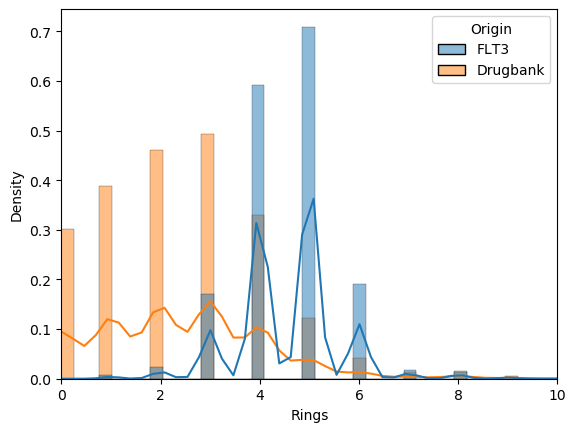

In [10]:
sns.histplot(data = descriptor_df, x = 'Rings', hue = 'Origin', stat = 'density', kde = True)
plt.xlim(0, 10)
plt.show()

(0, 20)

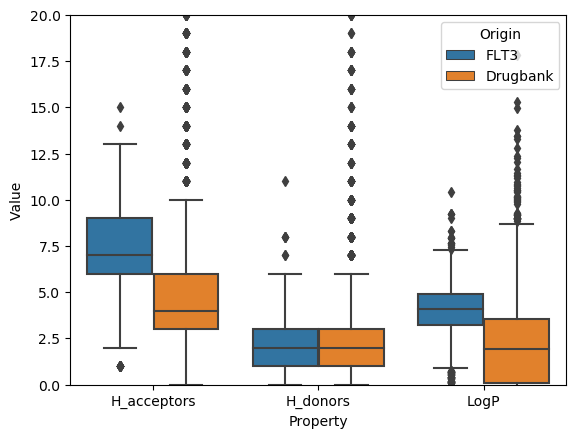

In [11]:
sns.boxplot(data = melted_df, x = 'Property', y = 'Value', hue = 'Origin')
plt.ylim(0, 20)

(0, 1000)

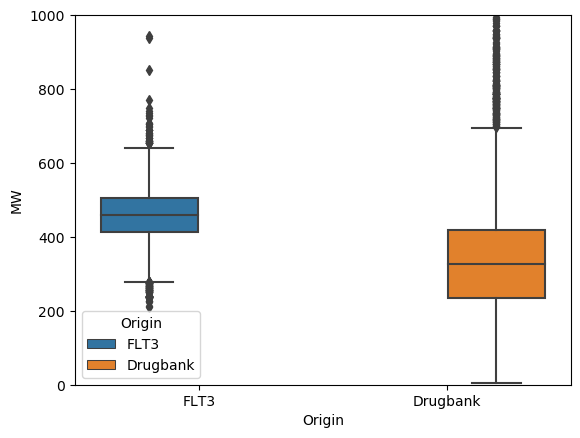

In [12]:
sns.boxplot(data = descriptor_df, x= 'Origin', y = 'MW', hue = 'Origin')
plt.ylim(0,1000)

In [13]:
for origin in ['FLT3', 'Drugbank']:
    origin_df = descriptor_df[descriptor_df['Origin'] == origin]
    origin_ro5 = len(origin_df[origin_df['RO5'] == True])
    print(f'{origin}: {origin_ro5} mols satisfy Lipinski RO5 ({origin_ro5*100/len(origin_df):.2f}%)')

FLT3: 4843 mols satisfy Lipinski RO5 (85.91%)
Drugbank: 6380 mols satisfy Lipinski RO5 (89.67%)


To sum up, Tyrosine kinase FLT3 active molecules tend to have more rings, more H bond acceptors, bigger mol mass and seem to be more hydrophobic. The difference does not seem to be big enough to affect druglikeness as can be seen on Lipinski RO5 comparison. 

# Scaffolds

In [14]:
def scaffold(mol):
    Chem.rdmolops.RemoveStereochemistry(mol) # get rid of stereo, doesn't matter much in scaffolds
    try:
        scaff = MurckoScaffold.MakeScaffoldGeneric(mol) # all atoms->C all bonds-> single
    except ValueError: # if the structure can't be represented by C atoms, just return no scaffold.
        # if such functionality is really desired, then generic graphs can be used instead of C
        return None
    scaff = MurckoScaffold.GetScaffoldForMol(scaff) # remove all sidechains
    return scaff

In [15]:
scaffolds = [scaffold(mol) for mol in molecules]

In [16]:
scaffolds_overview = dict()
for i,scaff in enumerate(scaffolds):
    scaff_smiles = Chem.MolToSmiles(scaff)
    scaff_smiles = Chem.CanonSmiles(scaff_smiles)
    if scaff_smiles not in scaffolds_overview:
        scaffolds_overview[scaff_smiles] = [] 
    scaffolds_overview[scaff_smiles].append(i)

In [17]:
print(f'There are {len(scaffolds_overview)} individual scaffolds')

There are 986 individual scaffolds


These top 10 scaffolds only take up 1428 of compounds (25.33%)


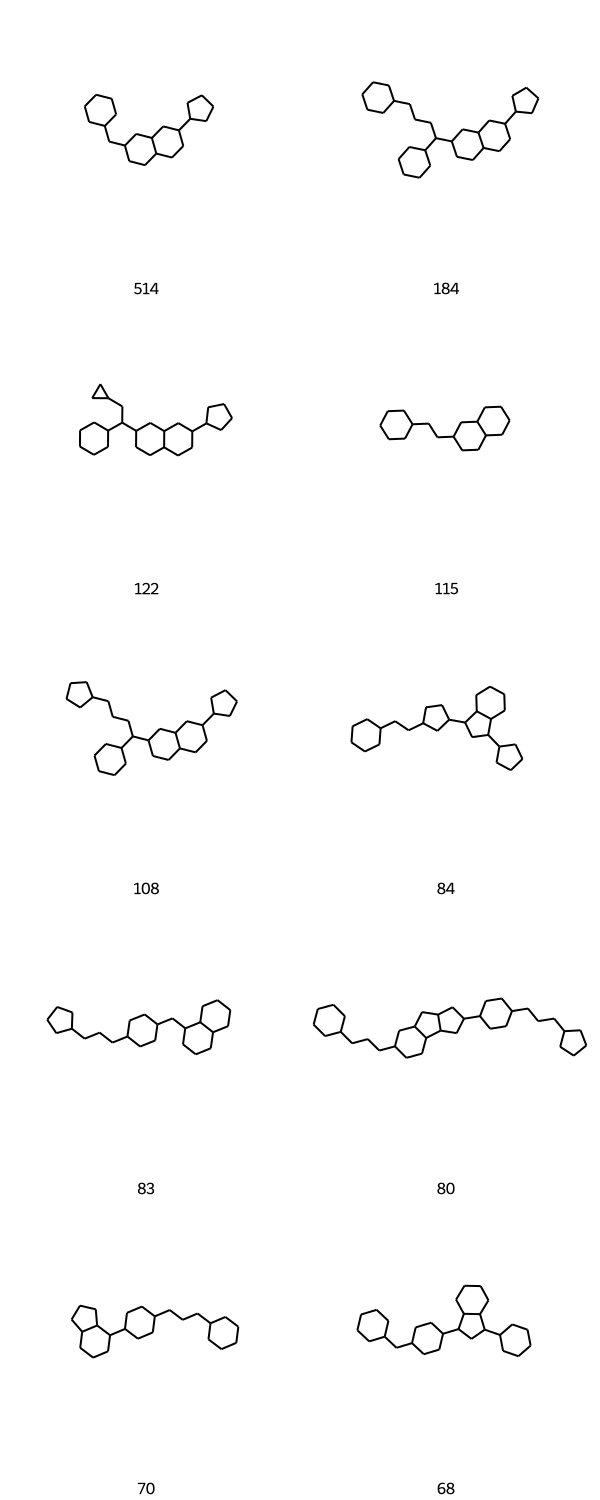

In [18]:
top10_sc = []
sum_top10 = 0
for sc, number in sorted(scaffolds_overview.items(), key=lambda x:len(x[1]), reverse = True)[:10]:
    top10_sc.append((Chem.MolFromSmiles(sc), len(number)))
    sum_top10 += len(number)
print(f'These top 10 scaffolds only take up {sum_top10} of compounds ({sum_top10*100/len(df):.2f}%)')
Draw.MolsToGridImage([scaffold for scaffold, count in top10_sc],
                     molsPerRow=2, subImgSize=(300,300),
                     legends=[str(count) for scaffold, count in top10_sc])
#Chem.MolFromSmiles(sorted(scaffolds_overview.items(), key=lambda x:len(x[1]), reverse = True)[-5][0])

# Chemical space visualisation

#### MQNs with PCA

In [19]:
drugbank_descriptors = [rdescriptors.MQNs_(mol) for mol in drugbank]
molecules_descriptors = [rdescriptors.MQNs_(mol) for mol in molecules]

In [20]:
MQNs_db = pd.DataFrame(drugbank_descriptors)
MQNs_db['Origin'] = ['Drugbank' for i in range(len(MQNs_db))]
MQNs_mol = pd.DataFrame(molecules_descriptors)
MQNs_mol['Origin'] = ['FTL3' for i in range(len(MQNs_mol))]
MQNs_df = pd.concat([MQNs_db, MQNs_mol], axis = 0)

Text(0, 0.5, 'PC2')

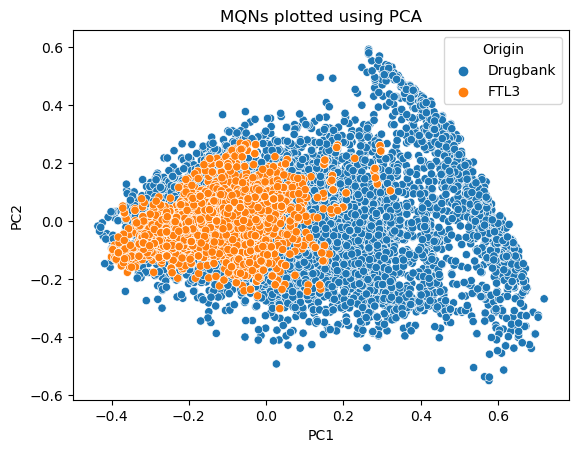

In [21]:
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.decomposition import PCA
standardized_mqns = normalize(MQNs_df.select_dtypes(include=['number']))
mnqs_pcad = PCA(n_components=4).fit_transform(standardized_mqns)
pca_df = pd.DataFrame(mnqs_pcad)
pca_df['Origin'] = list(MQNs_df['Origin'])
sns.scatterplot(data = pca_df, x = 0, y = 1, hue = 'Origin')
plt.title('MQNs plotted using PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
# plt.xlim(-0.5,0.5)
# plt.ylim(-0.5,0.5)

#### Fingerprints with t-SNE

In [22]:
from rdkit.Chem import AllChem as Chem
drugbank_fpts = [Chem.GetMorganFingerprintAsBitVect(mol,2,nBits=1024) for mol in drugbank]
molecules_fpts = [Chem.GetMorganFingerprintAsBitVect(mol,2,nBits=1024) for mol in molecules]
dbdf = pd.DataFrame(drugbank_fpts)
moldf = pd.DataFrame(molecules_fpts)
fpts_df = pd.concat([dbdf, moldf], axis = 0)

In [ ]:
from scipy.spatial import distance
from sklearn.manifold import TSNE

dist_matrix = distance.pdist(list(fpts_df[0]), metric = 'jaccard')
dist_matrix_squared = distance.squareform(dist_matrix)

array([0.62893082, 0.59285714, 0.50724638, ..., 0.91919192, 0.83486239,
       0.8440367 ])

c:\Users\schimmej\Anaconda3\envs\cdd\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
c:\Users\schimmej\Anaconda3\envs\cdd\lib\site-packages\sklearn\manifold\_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


Text(0, 0.5, 't-SNE_y')

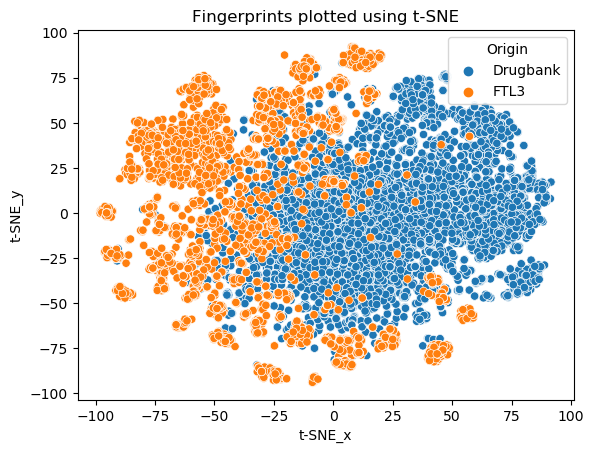

In [29]:
tsne = TSNE(n_components=2, metric="precomputed", init="random")
fpts_tsned = tsne.fit_transform(dist_matrix_squared)
tsne_df = pd.DataFrame(fpts_tsned)
tsne_df['Origin'] = list(MQNs_df['Origin'])
sns.scatterplot(data = tsne_df, x = 0, y = 1, hue = 'Origin')
plt.title('Fingerprints plotted using t-SNE')
plt.xlabel('t-SNE_x')
plt.ylabel('t-SNE_y')

# Training a model

#### Classification: FTL3 vs. Drugbank

In [32]:
drugbank_fpts = [list(Chem.GetMorganFingerprintAsBitVect(mol,2,nBits=1024)) for mol in drugbank]
molecules_fpts = [list(Chem.GetMorganFingerprintAsBitVect(mol,2,nBits=1024)) for mol in molecules]
dbdf = pd.DataFrame(drugbank_fpts)
moldf = pd.DataFrame(molecules_fpts)
fpts_df = pd.concat([dbdf, moldf], axis = 0)
fpts_df['Origin'] = list(MQNs_df['Origin'])

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X, Y = fpts_df.select_dtypes(include=['number']), fpts_df['Origin']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle = True)

model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [48]:
from sklearn.metrics import accuracy_score, confusion_matrix
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.9788318306546452
[[1414   23]
 [  31 1083]]


#### Regression: pCheMBL Value prediction

In [103]:
fitting_df = df[['Smiles', 'pChEMBL Value']]
fitting_df = fitting_df[fitting_df['pChEMBL Value'].notna()]
